<a href="https://colab.research.google.com/github/shawntharoo/GoogleColabProjects/blob/main/Copy_of_MBA509_A3_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 142345 Kaluthara Koralalage Sandakelum Tharindu Adikaram_image_captioning
# MBA509 Assessment 3: Apply AI to detect and caption images

This Python notebook:
* will fetch compressed image file from a remote data storage (wasabi S3 bucket)
* fetch the corresponding descriptions (annotations) for each  of the  images
* extract the images to Google Drive
* use InceptionV3 to read images and build features
* create and Encoder and Decoder with Tensorflow & Keras


# Remember to go to RUNTIME -> Change runtime type  -> and make sure that you set to GPU

In [ ]:
# this is the workaround for GPU error cuDNN
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 43 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 10s (41.5 MB/s)
(Reading database ... 155632 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155610 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+

In [ ]:
%pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 28.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 5.8 MB 53.3 MB/s 
     |████████████████████████████████| 438 kB 69.4 MB/s 
     |████████████████████████████████| 1.6 MB 68.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

**Import Libraries**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as tf_text
from keras.backend import set_session
import keras

In [ ]:
import logging

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
import json

In [ ]:
import collections
import random
from collections import Counter 

In [ ]:
import sys, time, os, warnings

In [ ]:
import requests, zipfile, io

In [ ]:
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

In [ ]:
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from PIL import Image as PImage

# Mount Google Drive
* The Flicker images will be extracted to YOUR Google Drive
* Later on, the AI pre-trained model will also be extracted to YOUR Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GET FLICKR IMAGES AND THEIR CORRESPONDING ANNOTATIONS

* flickr: https://www.flickr.com/
* flickr relied on crowdsourced & expert to create annotations (descriptions) of what are contained in images

**Get and extract zipfiles**

Notes: 
* this will extract the images in your Google Drive
* once the images have been extracted and  stored in Google Drive - you  don't need to run this part again


A: Extract images to Google Drive

In [ ]:
zip_file_url  = 'https://s3.ap-northeast-1.wasabisys.com/pubdatasets/flickr8/Flickr8k_Dataset.zip'
req = requests.get(zip_file_url)
zipped = zipfile.ZipFile(io.BytesIO(req.content))
zipped.extractall('/content/drive/MyDrive/images/')

## If the zip file is stored in your Google drive

In [ ]:
# import zipfile from Google drive

# you must specify the path to where the zip file is
# with zipfile.ZipFile('/content/drive/MyDrive/flickr/Flickr8k_Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/flickr/images')

## Where Images and Annotations are stored

C: If you are using the usual Google Drive

In [ ]:
# the location of the Flickr8K_ photos
flickr_jpg = "/content/drive/MyDrive/images/Flicker8k_Dataset/"

In [ ]:
flickr_jpg

### Retreive the corresponding captions

In [ ]:
# The location of the caption file
flickr_text = "https://s3.ap-northeast-1.wasabisys.com/pubdatasets/flickr8/Flickr8k.token.txt"

In [ ]:
flicker_annote  = pd.read_csv(flickr_text, header=None, delimiter='\t')

In [ ]:
flicker_annote

In [ ]:
# create column names
flicker_annote.columns = ['image_name', 'caption']

In [ ]:
flicker_annote

**Strip the # numbers after the .jpg filename extension**

In [ ]:
flicker_annote.image_name  = flicker_annote['image_name'].map(lambda x: x.rstrip('#01234'))

In [ ]:
flicker_annote

**Create image_id column in dataframe**

In [ ]:
flicker_annote['image_id']  = flicker_annote['image_name'].map(lambda x: x.rstrip('.jpg'))

In [ ]:
flicker_annote

**Re-arrange order of columns**

In [ ]:
flicker_annote = flicker_annote[['image_id', 'image_name', 'caption']]

In [ ]:
flicker_annote

**Examine files in the folder**

In [ ]:
from os import listdir
from os.path import isfile, join
only_image_files = [f for f in listdir('/content/drive/MyDrive/images/Flicker8k_Dataset/') if f.endswith('.jpg')]

In [ ]:
only_image_files

## Create a dataframe

In [ ]:
only_image_files_df = pd.DataFrame(only_image_files,  columns=['image_path'])

In [ ]:
only_image_files_df

**Merge dataframes**

In [ ]:
captioning = pd.merge(only_image_files_df, flicker_annote,  how='left', left_on=['image_path'], right_on = ['image_name'])

In [ ]:
captioning

**Add location or PATH of images to dataframe**

In [ ]:
# increase the width of the column so we can see more details
pd.set_option('max_colwidth', 400)

## This  is  the path to the extract Flickr images dataset

B: If you are using MacOS  (or Google Drive)

In [ ]:
PATH = '/content/drive/MyDrive/images/Flicker8k_Dataset/'

captioning['image_path'] = PATH + captioning['image_name'] 

In [ ]:
captioning

## Preprocess captions

In [ ]:
# convert all words to lower case
captioning.caption = captioning['caption'].apply(lambda x: x.lower())

In [ ]:
captioning

In [ ]:
# put a <start> and <end> tags around captions
captioning.caption = captioning['caption'].apply(lambda x: f'<start> {x} <end>')

In [ ]:
captioning

##  Create a list for all the captions - grouping by each unique images

In [ ]:
captioning_list = captioning.groupby(['image_path']).apply(lambda x: x.to_dict(orient='list'))

In [ ]:
captioning_list

In [ ]:
len(captioning_list)

In [ ]:
# print out all the captions in the list
for key in captioning_list.keys():
  print(captioning_list[key]['caption'])

In [ ]:
img_where = captioning_list[0]

In [ ]:
img_where

In [ ]:
img_where['caption'][0]

In [ ]:
image_where_path = img_where['image_path']

In [ ]:
image_where_path[0]

In [ ]:
Image.open(image_where_path[0])

## Create a list of captions and where the corresponding images are

In [ ]:
train_captions = []
image_pathname_vector = []

for key in captioning_list.keys():
  caption_list = captioning_list[key]['caption']
  train_captions.extend(caption_list)
  image_pathname_vector.extend([key] * len(caption_list))

## Examine the  first set of images and captions

In [ ]:
train_captions[0]

In [ ]:
image_pathname_vector[0]

In [ ]:
print(train_captions[0])
Image.open(image_pathname_vector[0])

# Image Pre-processing with InceptionV3

**Function load_image prepares images in the InceptionV3 format**

**InceptionV3 Model with Pre-trained Imagenet Weights**

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input

hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# **IMPORTANT: Delete pervious binary features from InceptionV3**

B: If you are using MacOS or Google Drive

In [ ]:
# MacOS or Google Drive
dir_name = "/content/drive/MyDrive/images/Flicker8k_Dataset/"
files = os.listdir(dir_name)

for item in files:
    if item.endswith(".npy"):
        os.remove(os.path.join(dir_name, item))

## Show the files inside the directory - **SHOULD** be only  JPEGs if the  ".npy" files have been deleted

B: If you are using MacOS or Google Drive

In [ ]:
dir_name = "/content/drive/MyDrive/images/Flicker8k_Dataset/"
files = os.listdir(dir_name)

In [ ]:
files

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg',
 '101654506_8eb26cfb60.jpg',
 '101669240_b2d3e7f17b.jpg',
 '1016887272_03199f49c4.jpg',
 '1019077836_6fc9b15408.jpg',
 '1019604187_d087bf9a5f.jpg',
 '1020651753_06077ec457.jpg',
 '1022454332_6af2c1449a.jpg',
 '1022454428_b6b660a67b.jpg',
 '1022975728_75515238d8.jpg',
 '102351840_323e3de834.jpg',
 '1024138940_f1fefbdce1.jpg',
 '102455176_5f8ead62d5.jpg',
 '1026685415_0431cbf574.jpg',
 '1028205764_7e8df9a2ea.jpg',
 '1030985833_b0902ea560.jpg',
 '103106960_e8a41d64f8.jpg',
 '103195344_5d2dc613a3.jpg',
 '103205630_682ca7285b.jpg',
 '1032122270_ea6f0beedb.jpg',
 '1032460886_4a598ed535.jpg',
 '1034276567_49bb87c51c.jpg',
 '104136873_5b5d41be75.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '1042590306_95dea

# INCEPTION_V3 FEATURE BUILDING

**Use InceptionV3 to create features from images**

*  A function to load images and resize them to 299x299 pixels for InceptionV3
* three channels: RGB


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

**Use InceptionV3 with pre-trained ImageNet to extract image features**

* InceptionV3: https://cloud.google.com/tpu/docs/inception-v3-advanced

* create equivalent features as a NumPy extension

In [ ]:
# get unique images
encode_train = sorted(set(image_pathname_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# load_image function defined above
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  # store the images in same folder as resize with npy extension
  # the numpy extensions are the features for the images
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
train_captions

### The **real** tokenisation of the captions

*  the example uses the **top 10000 words as AI's vocabulary** - that is, what AI will write as it detects entities in images

* this vocabularly could be increases to the top 10000 words


In [ ]:
# choose the top N words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [ ]:
tokenizer.fit_on_texts(train_captions)

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
print(tokenizer.word_index)

In [ ]:
train_seqs

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 5160, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4],
 [3, 2, 16, 10, 9, 2, 844, 10, 18, 344, 4],
 [3, 2, 16, 10, 9, 2, 1576, 236, 10, 35, 11, 138, 83, 7, 6, 152, 4],
 [3, 2, 16, 10, 9, 2, 15, 10, 11, 28, 1002, 18, 641, 23, 138, 83, 5, 6, 73, 4],
 [3, 14, 32, 13, 742, 2654, 90, 23, 138, 83, 7, 6, 152, 4],
 [3, 14, 32, 7, 728, 806, 322, 138, 83, 4],
 [3,
  2,
  41,
  20,
  165,
  5,
  607,
  107,
  5,
  49,
  13,
  2,
  595,
  1194,
  11,
  61,
  221,
  5,
  2,
  977,
  4],
 [3, 2, 41, 20, 8, 50, 5, 49, 13, 2, 56, 595, 1194, 4],
 [3,
  2,
  54,
  20,
  5,
  6,
  42,
  115,
  11,
  3422,
  5,
  49,
  13,
  2,
  15,
  2439,
  11,
  2,
  1194,
  7,
  150,
  4],
 [3, 190, 8, 2, 20, 11, 1577, 50, 5, 49, 13, 2, 1194, 773, 4],
 [3, 27, 20, 11, 1577, 773, 82, 5, 6, 42, 4],
 [3, 2, 12, 647

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

In [ ]:
# find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
max_length

39

## Split data into training and validation datasets

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_pathname_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

In [ ]:
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())

# random shuffle images
random.shuffle(img_keys)

# 80% split
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [ ]:
# the training dataset
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

In [ ]:
# the validation dataset
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

In [ ]:
# configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# the shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

# Finally, the dataset to feed into AI

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Convolutional Neural Networks - with Attention Mechanism

* Keras Model subclassing:  https://www.tensorflow.org/api_docs/python/tf/keras/Model

* Dense layers: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense


In [ ]:
# Google authors
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Create the Attention Mechanism for the AI

In [ ]:
#  the blueprint for Bahdanau Attention mechanism
class BahdanauAttention(tf.keras.Model):
  
  def __init__(self, units):

    # build dense layers
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # unnormalized score for each image feature
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### Convolutional Neural Network (CNN) - **Encoder**

In [ ]:
# convolutional neural network
class CNN_Encoder(tf.keras.Model):
    # the encoder get the features matrix and passes those 
    # features through a fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Recurrent Neural Network (RNN) - **Decoder**

In [ ]:
# recurrent neural network
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    # gated recurrent neural network
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)
    
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # attention mechanism
    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

### BUILD THE ENCODER, DECODER AND ATTENTION FROM THE BLUE PRINTS DEFINED ABOVE

In [ ]:
# the encoder - takes features built with inceptionv3
encoder = CNN_Encoder(embedding_dim)

# the decoder
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### Machine Learning Optimizers

* Adam algorithm: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

* Loses: https://www.tensorflow.org/api_docs/python/tf/losses

In [ ]:
optimizer = tf.keras.optimizers.Adam()

# computes the crossentropy loss between the labels and predictions
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  losses = loss_object(real, pred)

  mask = tf.cast(mask, dtype=losses.dtype)
  losses *= mask

  return tf.reduce_mean(losses)

# Checkpoints

* If you are running  this notebook for the  first  time  and want to do all the  training  yourself, then run Checkpoint Method A.

* If you are running this notebook and would like to use a pre-trained model, then run Checkpoint Method B.


### Checkpoint Method A: Save learning at each checkpoints

### The idea is to save (max_to_keep) as many as there are EPOCHS

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:

  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

# Restore Pre-trained CNN/RNN/Attention
* This is a model that has been trained to 50 EPOCHS.

In [ ]:
check_point_zip_file_url  = 'https://s3.ap-northeast-1.wasabisys.com/pubdatasets/image_captions/checkpoints/train/checkpoints.zip'
req = requests.get(check_point_zip_file_url)
zipped = zipfile.ZipFile(io.BytesIO(req.content))
zipped.extractall('/content/drive/MyDrive/ai/')

# Locate where the downloaded checkpoint files are

In [ ]:
# change this to where the pre-trained checkpoint have been extracted to your Google Drive
checkpoint_path = "/content/drive/MyDrive/ai/image_captions/checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

start_epoch = 0
if ckpt_manager.latest_checkpoint:

  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

# TRAINING AI - Define the training steps

* GradientTape: https://www.tensorflow.org/guide/autodiff

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # take and decode input  features
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for idx in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, idx], predictions)

          dec_input = tf.expand_dims(target[:, idx], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  # compute the gradient that was stored on the tape
  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

# Training AI - Execute training

### Notes:  Since  we  are using a pre-trained model, leave EPOCH = 1 as therer will be no training.

In [ ]:
# the number of epochs can change
EPOCHS = 1

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        # batch loss and total loss
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        # print output every 100 batches
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'EPOCH {epoch+1} BATCH {batch} LOSS {average_batch_loss:.4f}')
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # save training progress as checkpoints
    if epoch % 5 == 0:
      ckpt_manager.save()

    # display progress of training
    print(f'EPOCH {epoch+1} LOSS {total_loss/num_steps:.6f}')

    # how long training took
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

EPOCH 1 BATCH 0 LOSS 2.8461
EPOCH 1 BATCH 100 LOSS 1.5958
EPOCH 1 BATCH 200 LOSS 1.3545
EPOCH 1 BATCH 300 LOSS 1.3450
EPOCH 1 BATCH 400 LOSS 1.1958
EPOCH 1 BATCH 500 LOSS 0.9961
EPOCH 1 LOSS 1.371239
Time taken for 1 epoch 412.13 sec



# PREDICTIONS

In [ ]:
def predict(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for idx in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[idx] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

# VISUALISATIONS

* default picture sizes in pixels: 10x10
* you can change this to e.g., 20x20 pixels

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    # the sizes of the visualisations in pixels
    # you can change these
    fig = plt.figure(figsize=(30, 30))

    len_result = len(result)
    for idx in range(len_result):
        
        temp_att = np.resize(attention_plot[idx], (8, 8))
        
        grid_size = max(np.ceil(len_result/2), 2)
        
        ax = fig.add_subplot(grid_size, grid_size, idx+1)
        
        ax.set_title(result[idx])
        
        img = ax.imshow(temp_image)
        
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

**Evaluate AI on validation image dataset**

Real human captions: <start> a group of people stand and sit on the dirt near a line of several white tents <end>
AI captions: several girls dogs goofing a dirt head <end>


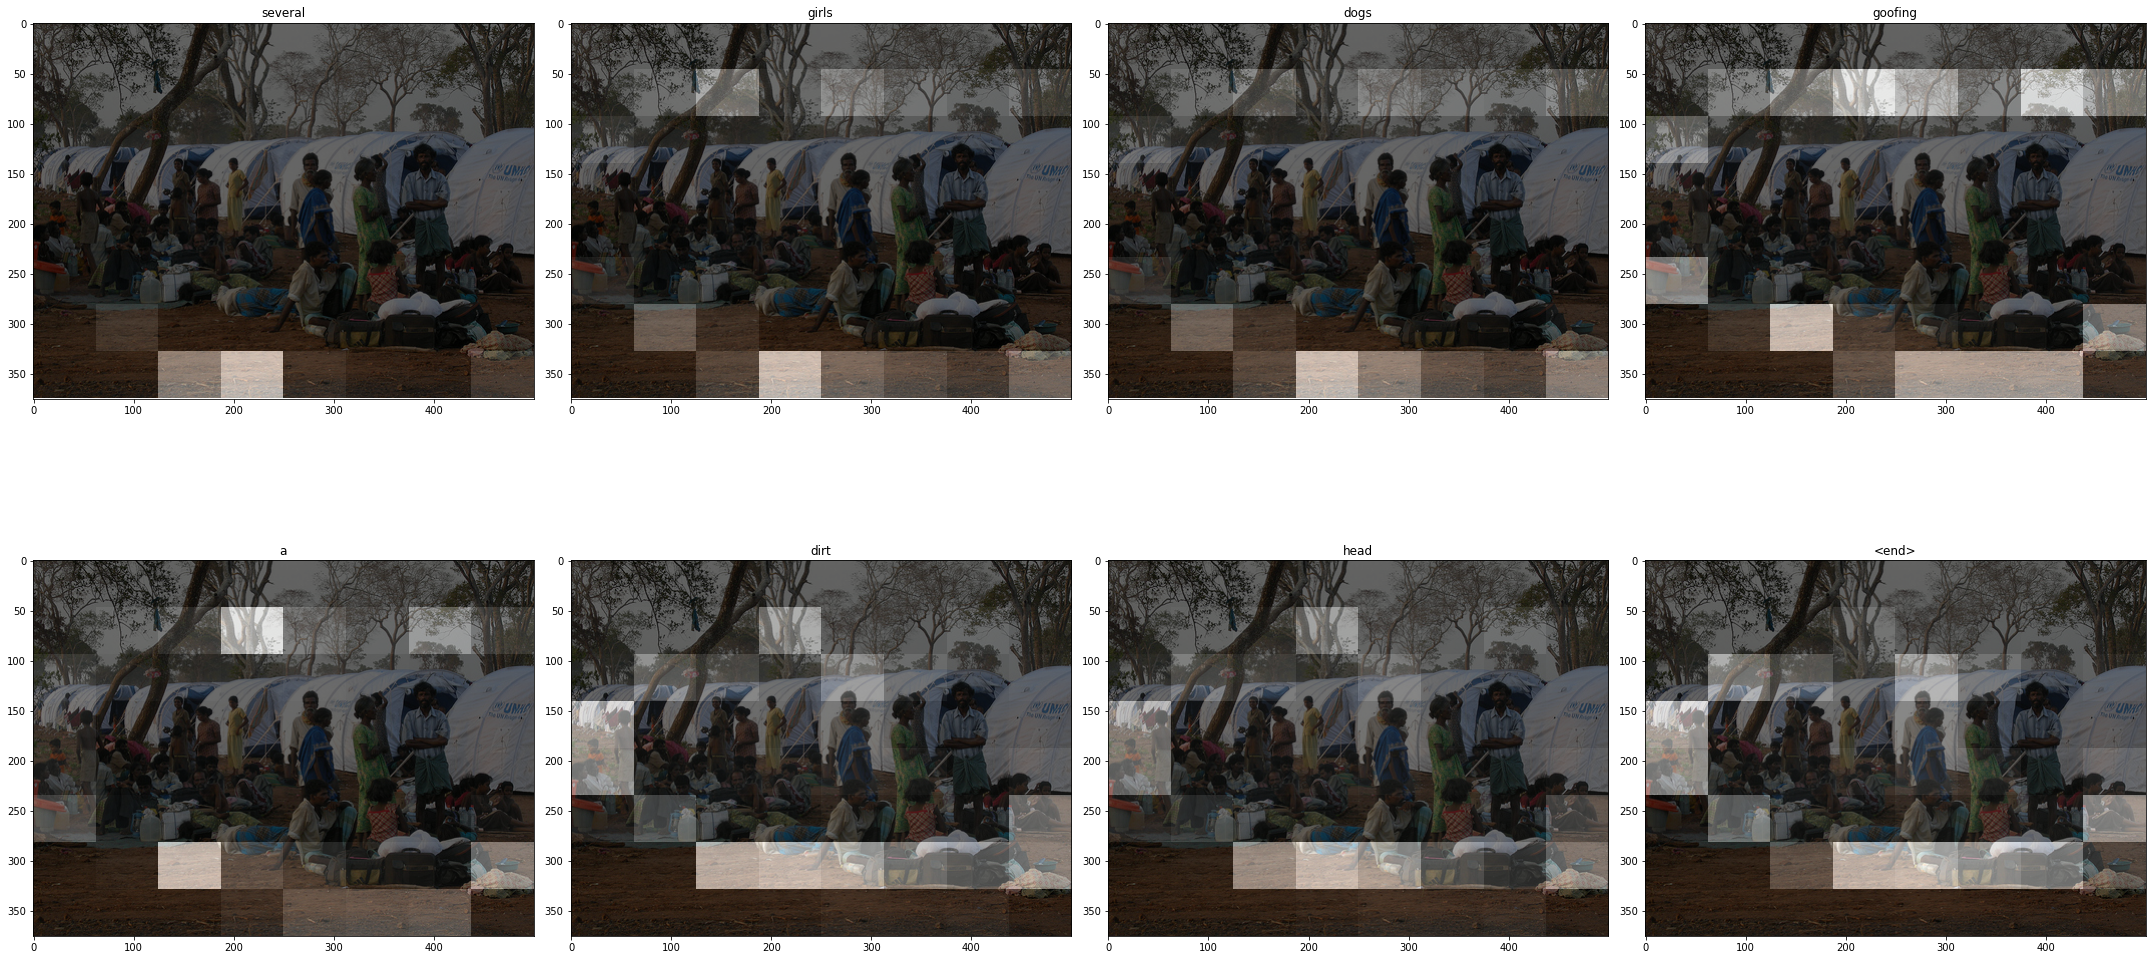

In [ ]:
# captions on the validation set
some_random_image = np.random.randint(0, len(img_name_val))
image = img_name_val[some_random_image]
real_caption = ' '.join([tokenizer.index_word[idx] for idx in cap_val[some_random_image] if idx not in [0]])

# predictions
result, attention_plot = predict(image)

print('Real human captions:', real_caption)
print('AI captions:', ' '.join(result))
plot_attention(image, result, attention_plot)

# PREDICT USING ANY IMAGE

# **First image**

#* YOU must specify where in Google drive you have stored YOUR advertising images

AI predicted caption for photo: a large work profusely pokes a large sign over at a edge of the water <end>


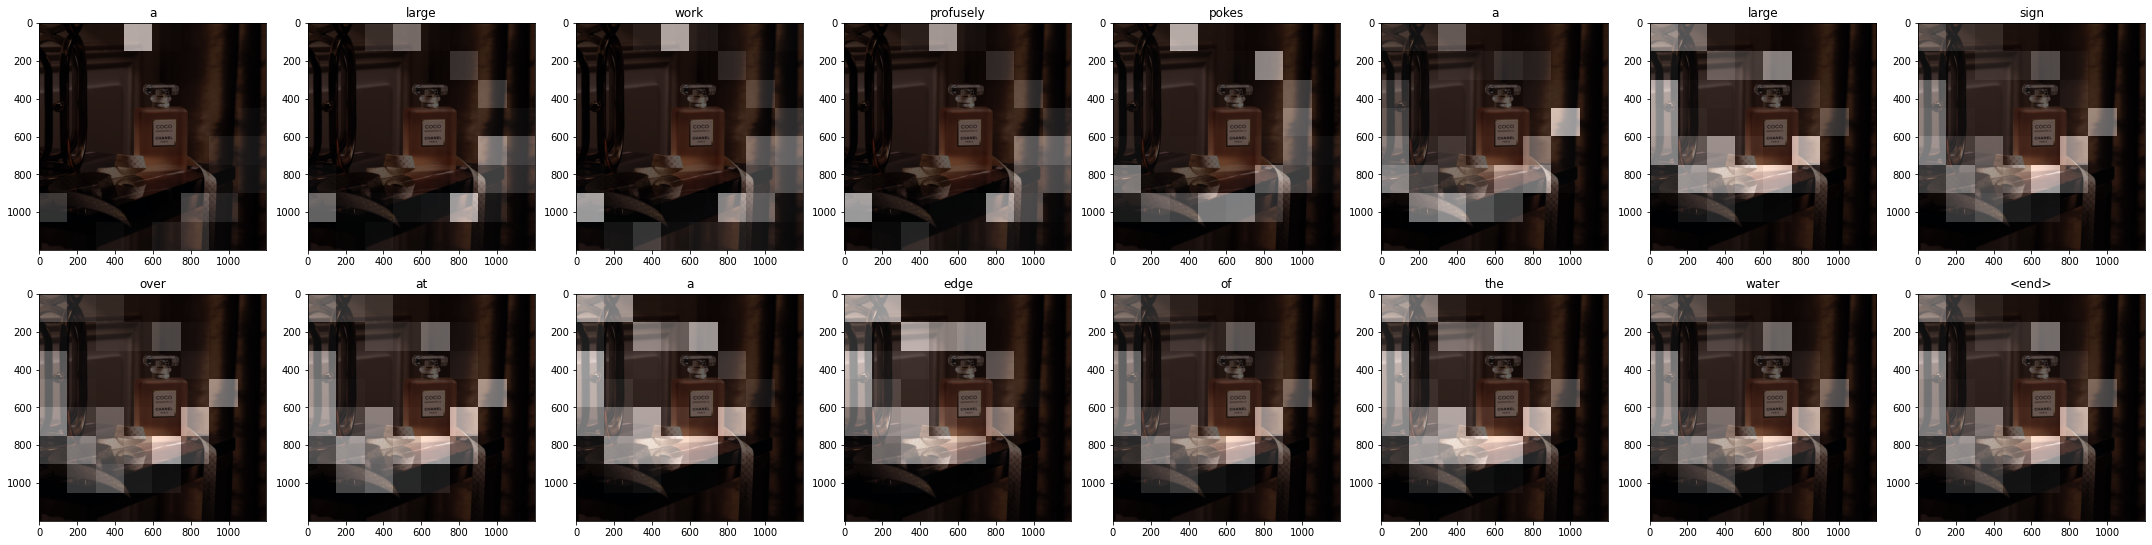

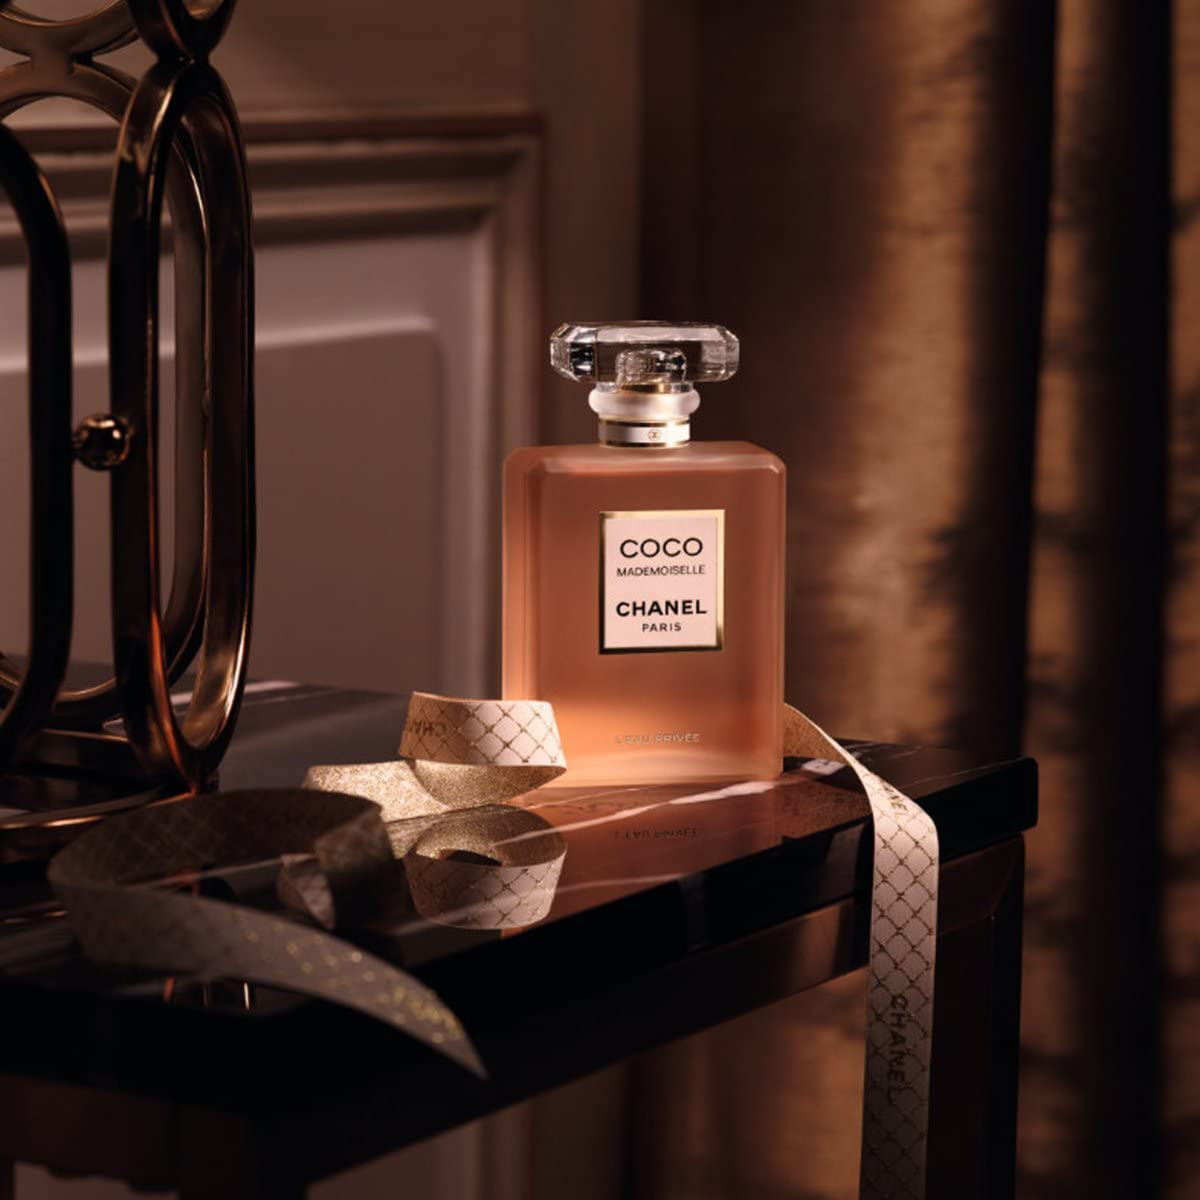

In [ ]:
# specify where the image is stored on your local PC/laptop
first_local_image_path = '/content/drive/MyDrive/509A3Images/chanel1.jpg'

results, attention_plots = predict(first_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(first_local_image_path, results, attention_plots)

# show the image
Image.open(first_local_image_path)

# **Second image**

AI predicted caption for photo: a towels splashing on the pedigree garbage incoming <end>


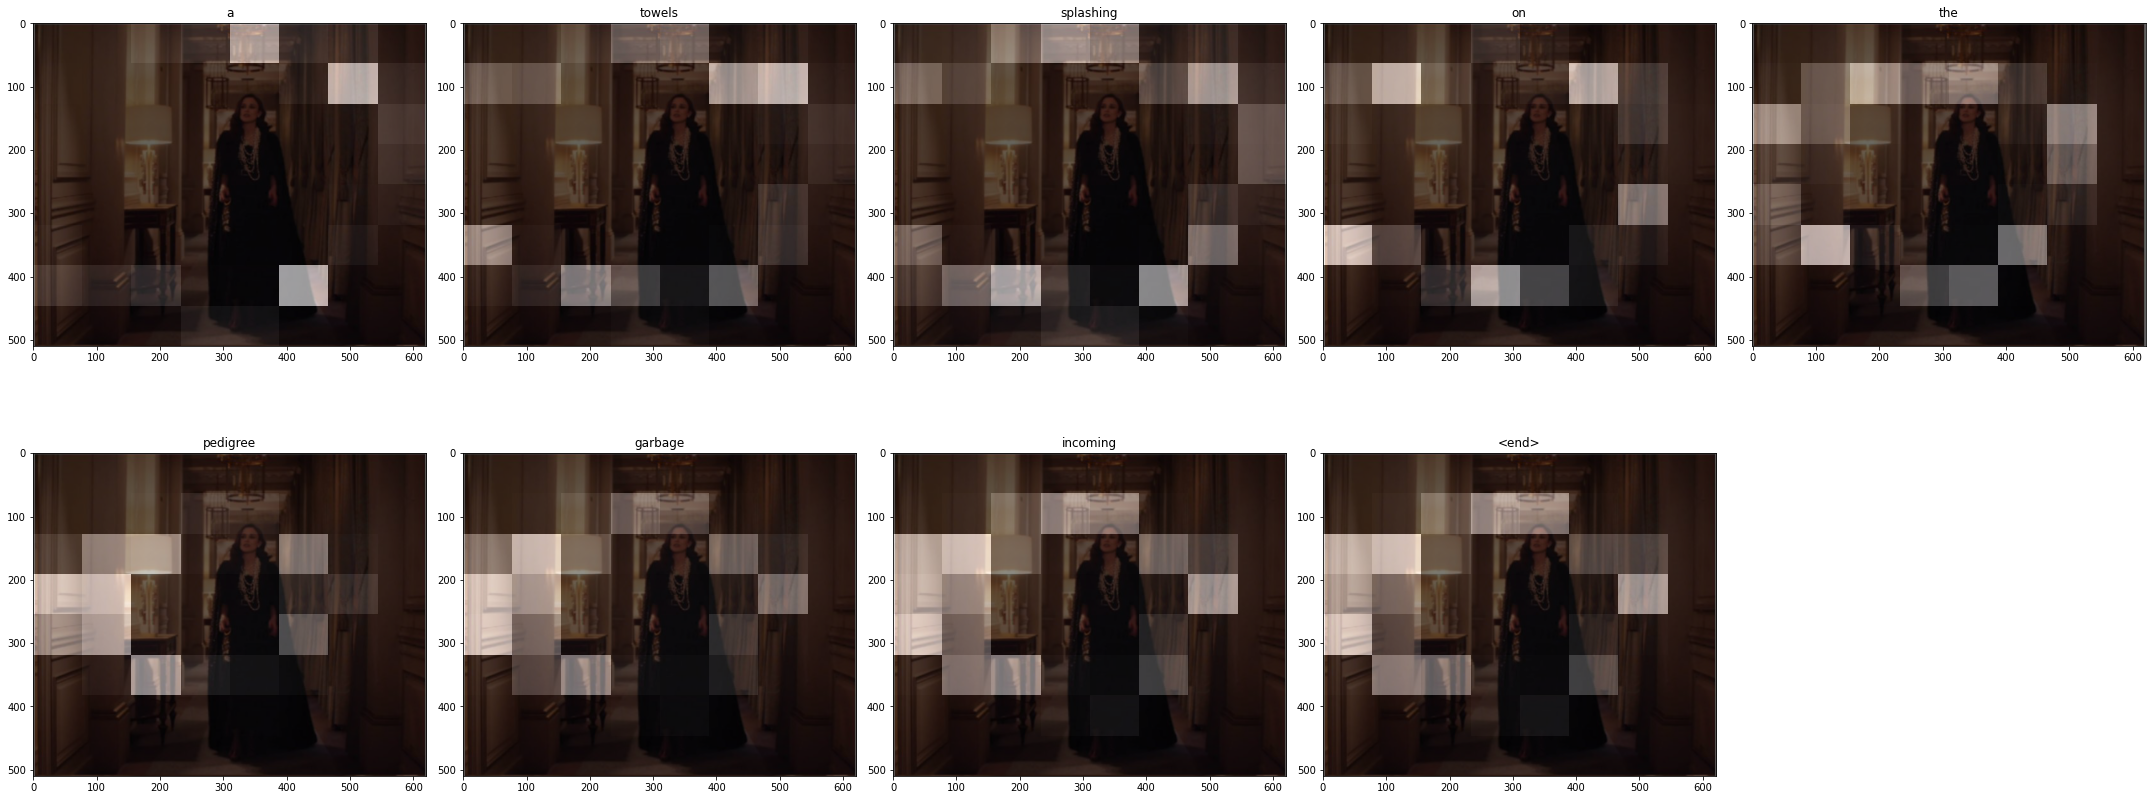

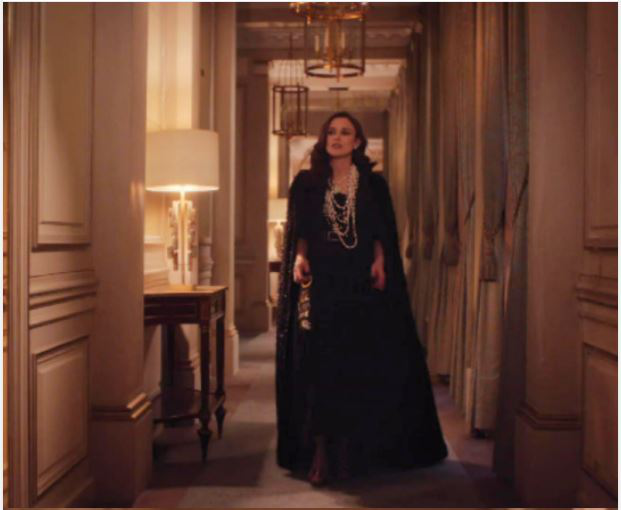

In [ ]:
# specify where the image is stored on your local PC/laptop
second_local_image_path = '/content/drive/MyDrive/509A3Images/chanel3.jpg'

results, attention_plots = predict(second_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(second_local_image_path, results, attention_plots)

# show the image
Image.open(second_local_image_path)

# **Third image**

In [ ]:
# specify where the image is stored on your local PC/laptop
third_local_image_path = '/content/drive/MyDrive/ads/HERO_Cambodia_PhnomPenh_RussianMarket.jpeg'

results, attention_plots = predict(third_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(third_local_image_path, results, attention_plots)

# show the image
Image.open(third_local_image_path)

# **To add more images: simply create a new code cell and copy and paste code - remember to point to the location of where your images are stored in Google Drive**

# Fourth Image

In [ ]:
# specify where the image is stored on your local PC/laptop
fourth_local_image_path = '/content/drive/MyDrive/ads/street-arcade-600x400px.jpeg'

results, attention_plots = predict(fourth_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(fourth_local_image_path, results, attention_plots)

# show the image
Image.open(fourth_local_image_path)

# Room for more advertising images

In [ ]:
# specify where the image is stored on your local PC/laptop
fifth_local_image_path = '/content/drive/MyDrive/ads/HERO_Cambodia_PhnomPenh_RussianMarket.jpeg'

results, attention_plots = predict(fifth_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(fifth_local_image_path, results, attention_plots)

# show the image
Image.open(fifth_local_image_path)

In [ ]:
# specify where the image is stored on your local PC/laptop
sixth_local_image_path = 'put the path to your image here'

results, attention_plots = predict(sixth_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(sixth_local_image_path, results, attention_plots)

# show the image
Image.open(sixth_local_image_path)

In [ ]:
# specify where the image is stored on your local PC/laptop
seventh_local_image_path = 'put the path to your image here'

results, attention_plots = predict(seventh_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(seventh_local_image_path, results, attention_plots)

# show the image
Image.open(seventh_local_image_path)

In [ ]:
# specify where the image is stored on your local PC/laptop
eight_local_image_path = 'put the path to your image here'

results, attention_plots = predict(eight_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(eight_local_image_path, results, attention_plots)

# show the image
Image.open(eight_local_image_path)

In [ ]:
# specify where the image is stored on your local PC/laptop
some_other_local_image_path = 'Paste_the_path_where_your_images_are_in_your_Google_Drive'

results, attention_plots = predict(some_other_local_image_path)
print('AI predicted caption for photo:', ' '.join(results))
plot_attention(some_other_local_image_path, results, attention_plots)

# show the image
Image.open(some_other_local_image_path)